# Group 9 assignment output

## Introduction: goal and methodology

The goal of the project is to try to explain after-the-fact the price movement of a stock during a day training a text classifier on the financial news headlines of the same day. Following the recomendation in the assignement notebook, we consider this a multilabel classification problem: the input is the string of the concatenated titles for a stock and the output is the class of the price movement (DOWN, FLAT, UP).

We identified four phases:
 - web scraping
 - dataset creation
 - model training
 - model evaluation

Therefore, this notebook is divided in four sections. In the first section, we present the code used to extract the financial headlines: we executed the code every day during the last working week, after the US market had closed so as to have the maximum number of articles published during day and the full daily price variation. In the second, we create and visualise the dataset. It is imbalanced but we decided to not rebalance the dataset as it is not big enough. Finally, in the last two sections, we train different models, we choose one based on performanced on the validation set and test it on the test set.


## Titles extraction

In [ ]:
# Import necessary libraries

import urllib.request
import bs4 as bs
import time
import datetime

import pandas as pd
import numpy as np
import yfinance as yf

We started reading the list of S&P 500 companies from Wikipedia and putting them into a DataFrame


In [ ]:

t_df = pd.read_html(
    'https://en.wikipedia.org/wiki/List_of_S%26P_500_companies')[0]

num_tickers = 500

tickers = list(t_df["Symbol"][0:num_tickers])

The purpose of this code is to fetch recent news articles for a list of stock tickers, extract the publication dates, and filter the articles to only include those published today

In [ ]:
# Ticker + STOCK

sleep_time  = 5

# Define a function to extract publication dates from the parsed HTML document

def extract_dates(parsed_doc):
    from math import floor
    today = datetime.datetime.now().date()
    dates = parsed_doc.find_all('pubdate')
    list_date = []
    for date  in dates:
        d = datetime.datetime.strptime( date.text, "%a, %d %b %Y %H:%M:%S GMT" )
        list_date += [floor((today - d.date()).days / 1)]                          #.days
    return list_date


# Define a function to get article titles and their publication dates for a given stock ticker

def get_titles(ticker, sleep_time):

    url = 'https://news.google.com/rss/search?hl=en-US&q='+ticker+'%20stock&gl=US&ceid=US:en'

    time.sleep(sleep_time) 

    doc = urllib.request.urlopen(url).read()
    parsed_doc = bs.BeautifulSoup(doc,'lxml')
    titles = parsed_doc.find_all('title')[1:]
    list_date = extract_dates(parsed_doc)                 
    dct = {"Ticker": [ ticker ]*len(titles) , "Titles" : titles, "Date" : list_date}
    title_df = pd.DataFrame(dct)
    title_df = title_df.sort_values(by="Date")
    title_df = title_df[title_df["Date"]==0]  # Filter articles that are published today (Date == 0)
    return title_df

# Initialize a list to store the DataFrames for each ticker

list_df = []                        

# Loop through each ticker and get the titles

for ticker in tickers:
    title = get_titles(ticker, sleep_time)
    list_df.append(title)
    print(title)

In [ ]:
# Concatenate all DataFrames in list_df into a single DataFrame

input_df = pd.concat(list_df)
input_df.shape
input_df.head()

This code calculates the percentage change in stock prices for a list of stock tickers, classify these changes into target categories, and add these values to a DataFrame.

In [ ]:
sleep_time = 5
threshold = 0.01

# Define a function to get the percentage change in stock prices

def get_var_prc(ticker, sleep_time):
    tickerData = yf.Ticker(ticker)
    time.sleep(sleep_time)  # Wait between requests
    df = tickerData.history()
    if len(df) < 2:
        print(f"Insufficient data for {ticker}")
        return None
    df['Change'] = df['Close'].diff()
    return df["Change"].iloc[-1] / df["Close"].iloc[-2]  # Use iloc for integer indexing

# Define a function to classify the percentage change into target categories

def get_target(x):
    if x < -threshold:
        return -1
    elif abs(x) < threshold:
        return 0
    else:
        return 1

# Loop through each ticker and add the percentage change and target category to the DataFrame

for ticker in input_df['Ticker']:
    var_prc = get_var_prc(ticker, sleep_time)
    if var_prc is not None:  # Check if data is available
        input_df.loc[input_df["Ticker"] == ticker, 'Var_prc'] = var_prc
        input_df.loc[input_df["Ticker"] == ticker, 'Target'] = input_df[input_df["Ticker"] == ticker]['Var_prc'].apply(get_target)
input_df.sample(n=5)

In [ ]:
today_date = datetime.datetime.today().strftime('%d%m')

filename = f"data_{today_date}_(puntoevirgola).csv"
input_df.to_csv(filename,sep=";")


'data_3105_(puntoevirgola).csv'

## Dataset creation

In [ ]:
#from google.colab import drive
#drive.mount('/content/drive')

In [5]:
#!pip install ktrain
#!pip install sentence_transformers
#!pip install --upgrade transformers==4.37.2     # otherwise ktrain.get_learner() does not work https://github.com/amaiya/ktrain/issues/523

First we import the necessary libraries and load the csv

In [6]:
import pandas as pd
import numpy as np
import tensorflow as tf
import ktrain
from ktrain import text

Now, we want to train our models only on stocks and price variations for which there is a minimum number of headlines. To choose the minimum number of headlines T, we plot the distribution of samples across targets for different choices of T.

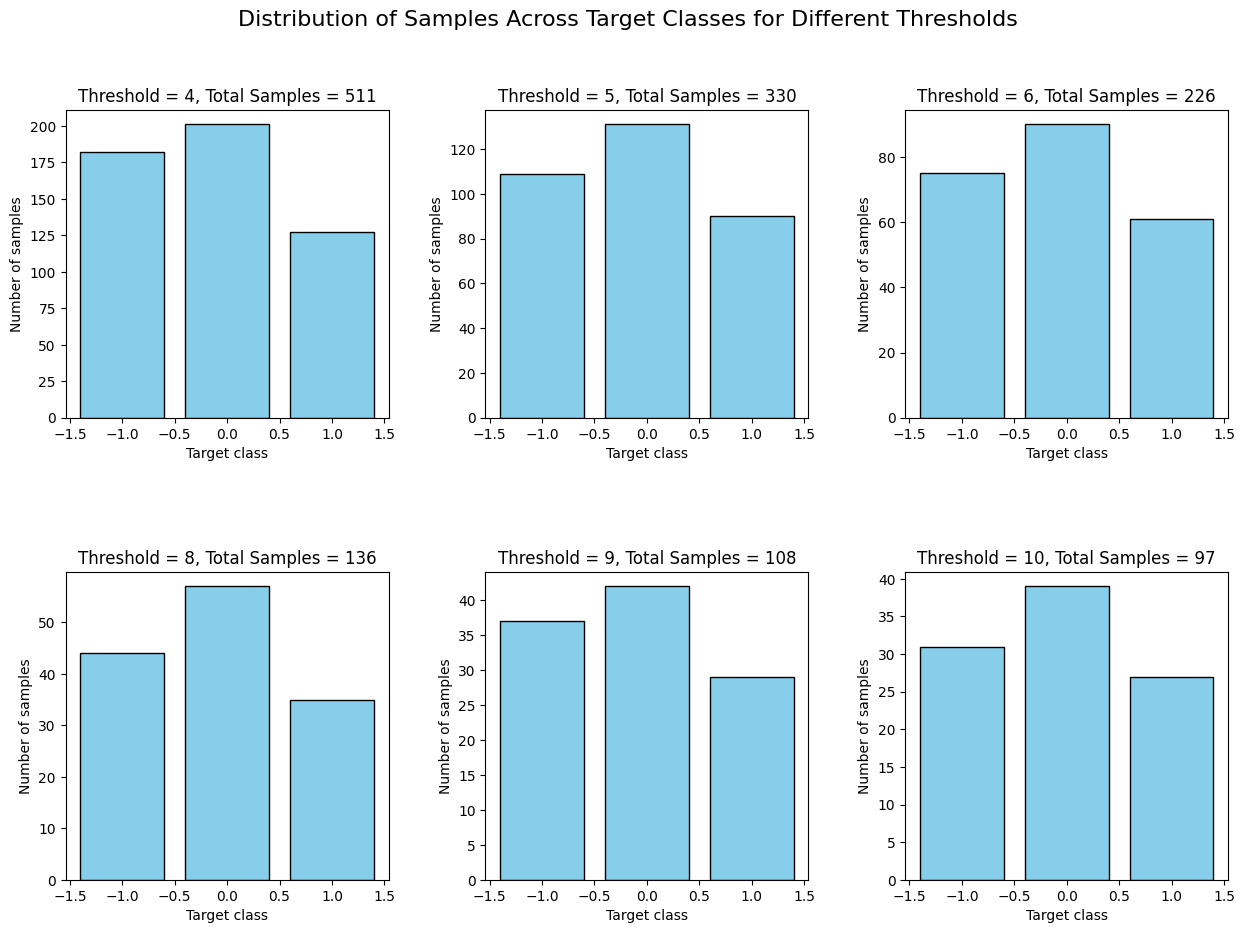

In [8]:
import matplotlib.pyplot as plt
import pandas as pd

# parameters to read the data
file_list_1 = ["/data_2805(puntoevirgola).csv", "/data_2905(puntoevirgola).csv","/data_3005(puntoevirgola).csv","/data_3105(puntoevirgola).csv"]
#path = "/content/drive/MyDrive/0.CARMAN_PROJECT/Friday_update_21_50/Data"      #path to Data folder
path = "Data"
file_list_1 = [ path+s for s in file_list_1 ]

# target values
target = [-1, 0, 1]
# input dataframe columns
col = ["Ticker"] + ["Article " + str(i + 1) for i in range(10)] + ["Target"] + ["Concatenated Titles"]

# Create subplots
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(15, 10))
fig.subplots_adjust(hspace=0.5, wspace=0.3)  # Adjust spacing between subplots

# we iterate over the thresholds
threshold = [4,5, 6, 8, 9, 10]
for i, T in enumerate(threshold):
    row_index = i // 3   # parameters for visualization
    col_index = i % 3

    # DataFrame initialization for each threshold
    all_data_set = pd.DataFrame(columns=col)

    # we iterate over the files to create the input dataframe
    for file_name in file_list_1:
        # we read the file
        data_set = pd.read_csv(file_name, sep=";")
        input_df = pd.DataFrame(columns=col)

        for ticker in data_set["Ticker"].unique():
            # we etract all the headlines related to a stock during a day
            ticker_df = data_set[data_set["Ticker"] == ticker]
            articles_list = ticker_df["Titles"].to_list()

            # and we add a row to the input dataframe only if there are enough articles
            if len(articles_list) >= T:
                ticker_target = ticker_df["Target"].iloc[0]
                new_row = [ticker] + articles_list[0:T] + [""] * (10 - T) + [ticker_target] + [" ".join(articles_list)]
                input_df.loc[len(input_df.index)] = new_row
        all_data_set = pd.concat([all_data_set, input_df], ignore_index=True)

    # Plot the distribution of samples for the current threshold
    ax = axes[row_index, col_index]
    ax.bar(target, [all_data_set[all_data_set["Target"] == t].shape[0] for t in target], color='skyblue',
           edgecolor='black')
    ax.set_xlabel('Target class')
    ax.set_ylabel('Number of samples')
    ax.set_title('Threshold = ' + str(T) + ", Total Samples = " + str(all_data_set.shape[0]))

# Add a common title for all subplots
fig.suptitle('Distribution of Samples Across Target Classes for Different Thresholds', fontsize=16)

plt.show()


It is clear that there is a tradeoff between the size of the threshold and the number of samples: we decided that a threshold of four is the minimum that we can consider.

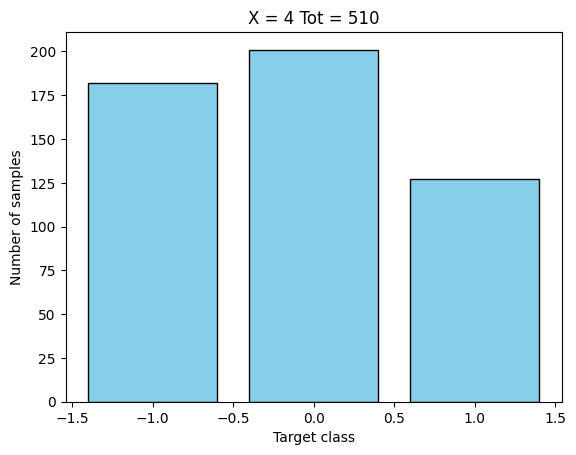

[182, 201, 127]


,Ticker,Article 1,Article 2,Article 3,Article 4,Article 5,Article 6,Article 7,Article 8,Article 9,Article 10,Target,Concatenated Titles
46,EQIX,"EQUINIX, INC. (NASDAQ: EQIX) DEADLINE ALERT: B...","Brown Advisory Inc. Buys New Stake in Equinix,...",Analyst Expectations For Equinix's Future - Eq...,Corient Private Wealth LLC Has $4.77 Million S...,,,,,,,0.0,"EQUINIX, INC. (NASDAQ: EQIX) DEADLINE ALERT: B..."
313,AXON,"Axon director Julie A. Cullivan sells $136,727...",PNC Financial Services Group Inc. Purchases 42...,"Axon Enterprise, Inc. (NASDAQ:AXON) Director J...",Nomura Asset Management Co. Ltd. Has $4.80 Mil...,,,,,,,0.0,"Axon director Julie A. Cullivan sells $136,727..."
431,EG,"1680 Shares in Everest Group, Ltd. (NYSE:EG) P...",Nomura Asset Management Co. Ltd. Takes Positio...,"55324 Shares in Everest Group, Ltd. (NYSE:EG) ...",US Bancorp DE Acquires New Shares in Everest G...,,,,,,,0.0,"1680 Shares in Everest Group, Ltd. (NYSE:EG) P..."


In [9]:
 # same code from before
all_data_set = pd.DataFrame(columns=col)
T = 4
for file_name in file_list_1:
    data_set = pd.read_csv(file_name, sep=";")
    input_df = pd.DataFrame(columns=col)
    for ticker in data_set["Ticker"].unique():
        ticker_df = data_set[data_set["Ticker"] == ticker]
        articles_list = ticker_df["Titles"].to_list()
        if len(articles_list) >= T:
            articles_list = articles_list[:T]
            ticker_target = ticker_df["Target"].iloc[0]
            new_row = [ticker] + articles_list + [""] * (10 - T) + [ticker_target] + [" ".join(articles_list)]
            input_df.loc[len(input_df.index)] = new_row
    all_data_set = pd.concat([all_data_set, input_df], ignore_index=True)
# Cleaning the columns
for i in range(1, 11):
    column_name = f'Article {i}'
    all_data_set[column_name] = all_data_set[column_name].str.replace('<title>', '').str.replace('</title>', '')
all_data_set["Concatenated Titles"] = all_data_set["Concatenated Titles"].str.replace('<title>', '').str.replace('</title>', '')

input_df = all_data_set

input_df = input_df.dropna()
'''
# if we want to rebalance the dataset
num_rows_to_keep = max(all_data_set[all_data_set["Target"] == 1].shape[0], all_data_set[all_data_set["Target"] == -1].shape[0])

subset_to_keep = all_data_set[all_data_set["Target"] == 0].sample(n = num_rows_to_keep)
input_df = pd.concat([subset_to_keep,all_data_set[all_data_set["Target"] == 1],all_data_set[all_data_set["Target"] == -1]])

'''
plt.bar( target ,[input_df[input_df["Target"] == t ].shape[0] for t in target], color='skyblue', edgecolor='black')

plt.xlabel('Target class')
plt.ylabel('Number of samples')
plt.title('X = '+ str(T)+" Tot = " +str(input_df.shape[0]))

plt.show()
print([input_df[input_df["Target"] == t ].shape[0] for t in target])
input_df.sample(n=3)

Now we divide the dataset in training set, validation set and test set

In [10]:
from sklearn.model_selection import train_test_split

X = input_df.filter(["Concatenated Titles"],axis=1)
Y = input_df.filter(["Target"],axis=1)
#print(Y)

x_train, x_test, y_train, y_test = train_test_split( X, Y, test_size=0.20, random_state=42)
x_train, x_val, y_train, y_val = train_test_split( x_train, y_train, test_size=0.20, random_state=42)

y_train = y_train + 1
y_test = y_test + 1
y_val = y_val + 1

## Model training and validation

We present three text classifiers:
 - a bert model,
 - a distilroberta concatenated with a neural network
 - a Text2Vec model concatenated with a neural network. \

The bert model has been the first model we trained: we noticed that a problem is that the transformer accepts strings of 500 maximum characters. So, we dealt with that in two different ways: in the second model we used a distilroberta finetuned for financial sentiment anlalysis to trasform the headlines in a binary array, and in the last model we generate a embedding of the concatenated headlines unsing a Text2vec model.

### bert-base-multilingual-uncased

As mentioned above, the input of the model is the string of the concatenated headlines. We consider this model as the benchmark as we apply exacly the steps we have seen in class:
 - we obtain the transformer to preprocess the data
 - we find the optimal learning rate
 - we train the classifier
 - we evaluate the performance on the validation set

In [11]:
model_name = 'bert-base-multilingual-uncased'
transformer = text.Transformer(model_name, maxlen=500, class_names= np.array([0,1,2]))

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


In [12]:
processed_train = transformer.preprocess_train(list(x_train["Concatenated Titles"]), list(y_train["Target"]))
processed_val = transformer.preprocess_test(list(x_val["Concatenated Titles"]), list(y_val["Target"]))

preprocessing train...
language: en
train sequence lengths:
	mean : 55
	95percentile : 68
	99percentile : 74


/usr/local/lib/python3.10/dist-packages/ktrain/utils.py:768: UserWarning: class_names implies classification but targets array contains float(s) instead of integers or strings
  warnings.warn(


Is Multi-Label? False
preprocessing test...
language: en
test sequence lengths:
	mean : 55
	95percentile : 64
	99percentile : 69


In [14]:
model = transformer.get_classifier()
batch_size = 5
learner = ktrain.get_learner(model, train_data=processed_train, val_data=processed_val, batch_size=batch_size)

simulating training for different learning rates... this may take a few moments...
65/65 [==============================] - 2287s 35s/step - loss: 36.8498 - accuracy: 0.3438


/usr/local/lib/python3.10/dist-packages/ktrain/lroptimize/lrfinder.py:267: UserWarning: Shape of array too small to calculate a numerical gradient, at least (edge_order + 1) elements are required.
  warnings.warn(str(e))




done.
Visually inspect loss plot and select learning rate associated with falling loss


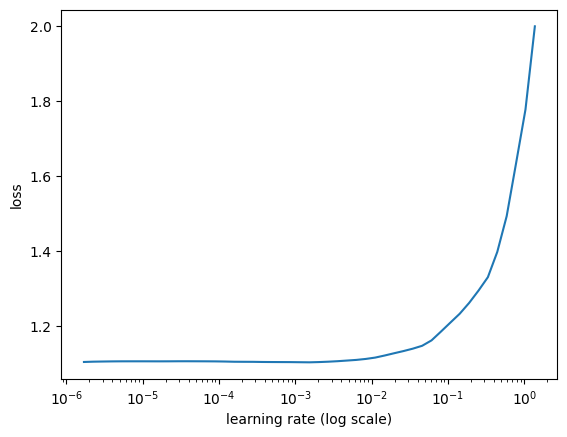

In [15]:
learner.lr_find(show_plot=True,  max_epochs=1)

We noticed that the plot above depends on the machine the code is run. With the plot above it is not clear what to do because the loss looks like it is increasing. Therefore, we have chosen a "small" learning rate of 1e-5

In [ ]:
learner.fit_onecycle(1e-5, 2)



begin training using onecycle policy with max lr of 1e-05...
Epoch 1/2
 1/66 [..............................] - ETA: 1:05:41 - loss: 1.1394 - accuracy: 0.4000

Classification Report (training set):
              precision    recall  f1-score   support

     Class 0       0.00      0.00      0.00       122
     Class 1       0.37      0.88      0.52       120
     Class 2       0.25      0.11      0.15        84

    accuracy                           0.35       326
   macro avg       0.21      0.33      0.22       326
weighted avg       0.20      0.35      0.23       326

Classification Report (validation set):
              precision    recall  f1-score   support

     Class 0       0.00      0.00      0.00        27
     Class 1       0.47      0.89      0.61        38
     Class 2       0.33      0.18      0.23        17

    accuracy                           0.45        82
   macro avg       0.27      0.36      0.28        82
weighted avg       0.28      0.45      0.33        82

[[  0 109  13]
 [  0 106  14]
 [  0  75   9]]


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classif

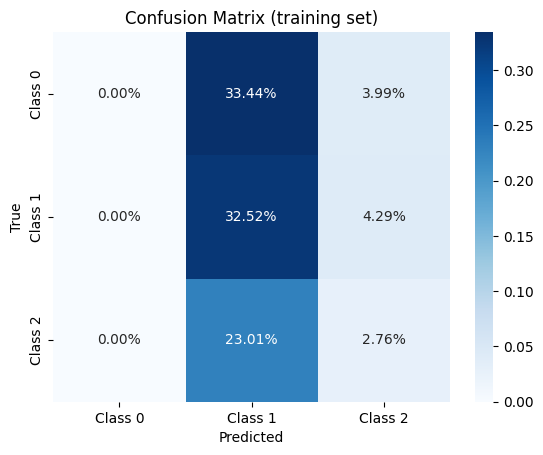

[[ 0 25  2]
 [ 0 34  4]
 [ 0 14  3]]


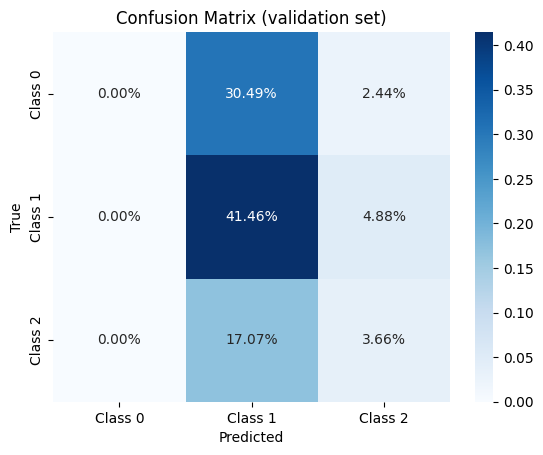

In [24]:
# Evaluating the model (training and validation set)
import numpy as np
import seaborn as sns
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report

# Making predictions
predictor = ktrain.get_predictor(learner.model, preproc=transformer)
y_train_pred = predictor.predict(list(x_train["Concatenated Titles"]), return_proba=False)
y_train_true = list(y_train["Target"])
y_val_pred = predictor.predict(list(x_val["Concatenated Titles"]), return_proba=False)
y_val_true = list(y_val["Target"])

# Classification report (training set)
class_names = ['Class 0', 'Class 1', 'Class 2']
print("Classification Report (training set):")
print(classification_report(y_train_true, y_train_pred, target_names=class_names))

# Classification report (validation set)
class_names = ['Class 0', 'Class 1', 'Class 2']
print("Classification Report (validation set):")
print(classification_report(y_val_true, y_val_pred, target_names=class_names))

# Confusion matrix (training set)
conf_matrix = confusion_matrix(y_train_true, y_train_pred)
print(conf_matrix)
sns.heatmap(conf_matrix/np.sum(conf_matrix), annot=True, fmt='.2%', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix (training set)')
plt.show()

# Confusion matrix (validation set)
conf_matrix = confusion_matrix(y_val_true, y_val_pred)
print(conf_matrix)
sns.heatmap(conf_matrix/np.sum(conf_matrix), annot=True, fmt='.2%', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix (validation set)')
plt.show()

**Class Performance**
*   The model fails entirely for Class 0
*   Class 1 shows the best performance among the three classes, with decent precision (0.47) and high recall (0.89)
*   Class 2 has moderate precision (0.33) but low recall (0.18)

**Overall Performance**
*   Accuracy (0.45) is low
*   Precision (0.28), recall (0.45), and F1-score (0.33) are all on the lower side

### distilroberta-finetuned

Here we use a pre-trained model to get a sentiment label for each headline and use that to generate an embedding used to train a neural network.

In [25]:
from sklearn.model_selection import train_test_split

articles_list = [ f"Article {i+1}" for i in range(T) ]
X_2 = input_df.filter(articles_list,axis=1)
Y = input_df.filter(["Target"],axis=1)

# we re-divide training , validation and test set beacuse X here is different, putting the same random state we should still get the same division.
x_train_2, x_test_2, y_train_2, y_test_2 = train_test_split( X_2, Y, test_size=0.20, random_state=42)
x_train_2, x_val_2,  y_train_2, y_val_2 = train_test_split( x_train_2, y_train_2, test_size=0.20, random_state=42)

y_train_2 = y_train_2 + 1
y_test_2 = y_test_2 + 1
y_val_2 = y_val_2+ 1

In [26]:
# Use a pipeline as a high-level helper
from transformers import pipeline

pipe = pipeline("text-classification", model="mrm8488/distilroberta-finetuned-financial-news-sentiment-analysis")
# Pipeline use example
'''
i = np.random.randint(X.shape[0])
s = X.iloc[i].to_list()
print(s[2])
print(pipe( s[2] )[0]["label"])
'''
def get_label(s):
    return pipe( s )[0]["label"]

Here we create a one hot encoding of the sentiment for each title

In [27]:
map_label_encoding = { "positive": np.array([0,0,1]), "neutral": np.array([0,1,0]),"negative": np.array([1,0,0]) }
num_sentiment = 3

# training input encoding
x_train_2_ones = np.zeros( (x_train_2.shape[0],T*num_sentiment))

for row_idx in range(x_train_2.shape[0]):
    articles_list = x_train_2.iloc[i].to_list()
    for i in range(len(articles_list)):    # len(s) = T
        x_train_2_ones[row_idx,i*3:i*3+3] = map_label_encoding[ get_label(articles_list[i])]

# validation input encoding
x_val_2_ones = np.zeros( (x_val_2.shape[0],T*num_sentiment))

for row_idx in range(x_val_2.shape[0]):
    articles_list = x_val_2.iloc[i].to_list()
    for i in range(len(articles_list)):    # len(s) = T
        x_val_2_ones[row_idx,i*3:i*3+3] = map_label_encoding[ get_label(articles_list[i])]

# test input encoding
x_test_2_ones = np.zeros( (x_test_2.shape[0],T*num_sentiment))

for row_idx in range(x_test_2.shape[0]):
    articles_list = x_test_2.iloc[i].to_list()
    for i in range(len(articles_list)):    # len(s) = T
        x_test_2_ones[row_idx,i*3:i*3+3] = map_label_encoding[ get_label(articles_list[i])]

x_train_2_ones[0]

array([0., 1., 0., 0., 1., 0., 0., 0., 1., 0., 1., 0.])

In [28]:
#to train the NN we need to convert integer output to binary array
num_classes = 3

y_train_dummy_2 = np.zeros((len(y_train_2), num_classes))
for i in range(0,len(y_train_2)):
    class_idx = round(y_train_2.Target.iloc[i])
    y_train_dummy_2[i, class_idx] = 1


y_val_dummy_2 = np.zeros((len(y_val_2), num_classes))
for i in range(0,len(y_val_2)):
  y_val_dummy_2[i,round(y_val_2.Target.iloc[i])] = 1

y_test_dummy_2 = np.zeros((len(y_test_2), num_classes))
for i in range(0,len(y_test_2)):
  y_test_dummy_2[i,round(y_test_2.Target.iloc[i])] = 1

In [29]:
import numpy as np
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers import Dense
from keras.optimizers import Adam

In [30]:
# Here we create several NN architechtures
c = x_train_2_ones.shape[1]
def create_m1(epo,lr,bat,x,y):
    model=Sequential()
    model.add(Dense(units=30, activation='relu', input_dim=c))
    model.add(Dense(units=100, activation='tanh'))
    model.add(Dense(units=3, activation='sigmoid'))    #output layer
    model.compile(loss='mse',                                    # tf.keras.losses.CategoricalCrossentropy should be more appropriate but I cannot make it work
                  optimizer=Adam(lr=lr,beta_1=0.9,beta_2=0.999))
    model.fit(x,y,epochs=epo,batch_size=bat,verbose=0)
    return model
def create_m2(epo,lr,bat,x,y):
    model=Sequential()
    model.add(Dense(units=30, activation='relu', input_dim=c))
    model.add(Dense(units=3, activation='sigmoid'))    #output layer
    model.compile(loss='mse',
                  optimizer=Adam(lr=lr,beta_1=0.9,beta_2=0.999))
    model.fit(x,y,epochs=epo,batch_size=bat,verbose=0)
    return model

def create_m3(epo,lr,bat,x,y):
    model=Sequential()
    model.add(Dense(units=300, activation='relu', input_dim=c))
    model.add(Dense(units=3, activation='sigmoid'))    #output layer
    model.compile(loss='mse',
                  optimizer=Adam(lr=lr,beta_1=0.9,beta_2=0.999))
    model.fit(x,y,epochs=epo,batch_size=bat,verbose=0)
    return model
def create_m4(epo,lr,bat,x,y):
    model=Sequential()
    model.add(Dense(units=900, activation='relu', input_dim=c))
    model.add(Dense(units=50, activation='tanh'))
    model.add(Dense(units=3, activation='sigmoid'))    #output layer
    model.compile(loss='mse',
                  optimizer=Adam(lr=lr,beta_1=0.9,beta_2=0.999))
    model.fit(x,y,epochs=epo,batch_size=bat,verbose=0)
    return model

def get_validation_missclas(y_pred, target):
    return np.sum(y_pred != target) / len(target)


In [ ]:
fun_lst = [create_m1,create_m2,create_m3,create_m4]
epo_list = [1,3, 5,20,100]
lr = 0.001                              # values between 0.001 and 0.0001 should be fine
batch_size_list = [5,8,10,20]
best_performance = 10
# 80 models will be trained
for function in fun_lst:
    for epo in epo_list:
        for bat in batch_size_list:
            model = function(epo,lr,bat,x_train_2_ones,y_train_dummy_2)
            pred_val_raw=model.predict(x_val_2_ones)
            pred_val = np.argmax(pred_val_raw, axis=1)
            miss = get_validation_missclas(pred_val, np.argmax(y_val_dummy_2, axis=1))
            if miss < best_performance:
                best_performance = miss
                opt_model, opt_fun, opt_epo, opt_bat = model, function, epo, bat

In [32]:
print("Lowest missclassification: ",best_performance,\
      "Optimal model: ",opt_fun, \
      "Optimal number of epoch: ",opt_epo,\
      "Optimal batch size: ", opt_bat,sep="\n")
predictions = opt_model.predict(x_val_2_ones)

Lowest missclassification: 
0.5365853658536586
Optimal model: 
<function create_m1 at 0x7ebe3abd2950>
Optimal number of epoch: 
1
Optimal batch size: 
20
3/3 [==============================] - 0s 3ms/step


Now that we have chosen the architechture we just have to evaluate the model

3/3 [==============================] - 0s 13ms/step
Classification Report (training set):
              precision    recall  f1-score   support

     Class 0       0.00      0.00      0.00       122
     Class 1       0.37      1.00      0.54       120
     Class 2       0.00      0.00      0.00        84

    accuracy                           0.37       326
   macro avg       0.12      0.33      0.18       326
weighted avg       0.14      0.37      0.20       326

Classification Report (validation set):
              precision    recall  f1-score   support

     Class 0       0.00      0.00      0.00        27
     Class 1       0.46      1.00      0.63        38
     Class 2       0.00      0.00      0.00        17

    accuracy                           0.46        82
   macro avg       0.15      0.33      0.21        82
weighted avg       0.21      0.46      0.29        82

[[  0 122   0]
 [  0 120   0]
 [  0  84   0]]


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classif

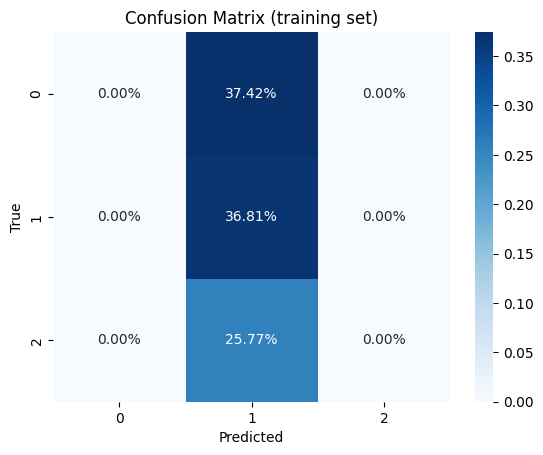

[[ 0 27  0]
 [ 0 38  0]
 [ 0 17  0]]


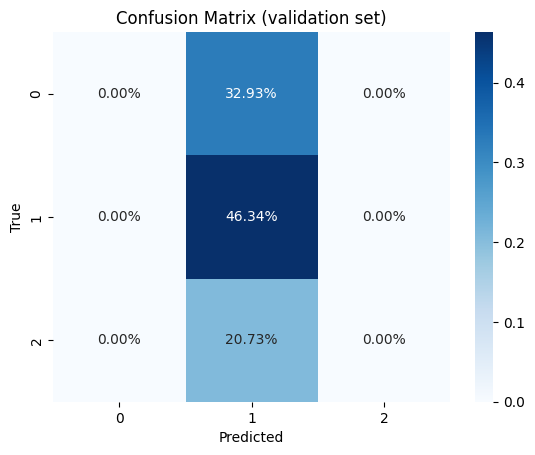

In [35]:
model  = opt_model
import seaborn as sns
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report

# Making predictions
pred_train = model.predict(x_train_2_ones)
pred_val = model.predict(x_val_2_ones)

# Converting predictions to binary arrays
def to_binary(pred):
    pred_binary = np.zeros(pred.shape)
    for i in range(len(pred)):
        pred_binary[i, pred[i, :].argmax()] = 1
    return pred_binary

pred_train_2 = to_binary(pred_train)
pred_val_2 = to_binary(pred_val)

# Converting predictions to class labels
y_train_pred_labels = np.argmax(pred_train, axis=1)
y_val_pred_labels = np.argmax(pred_val, axis=1)

# Converting one-hot encoded true labels to class labels
y_train_true_labels = np.argmax(y_train_dummy_2, axis=1)
y_val_true_labels = np.argmax(y_val_dummy_2, axis=1)

# Evaluating the model (training and validation set)

# Classification report (training set)
class_names = ['Class 0', 'Class 1', 'Class 2']
print("Classification Report (training set):")
print(classification_report(y_train_true_labels, y_train_pred_labels, target_names=class_names))

# Classification report (validation set)
class_names = ['Class 0', 'Class 1', 'Class 2']
print("Classification Report (validation set):")
print(classification_report(y_val_true_labels, y_val_pred_labels, target_names=class_names))

# Confusion matrix (training set)
print(confusion_matrix(y_train_true_labels, y_train_pred_labels))
conf_matrix = confusion_matrix(y_train_true_labels, y_train_pred_labels)
sns.heatmap(conf_matrix/np.sum(conf_matrix), annot=True, fmt='.2%', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix (training set)')
plt.show()

# Confusion matrix (validation set)
print(confusion_matrix(y_val_true_labels, y_val_pred_labels))
conf_matrix = confusion_matrix(y_val_true_labels, y_val_pred_labels)
sns.heatmap(conf_matrix/np.sum(conf_matrix), annot=True, fmt='.2%', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix (validation set)')
plt.show()

**Class Performance**
*   The model fails entirely for Class 0 with all instances being misclassfied as Class 1
*   Class 1 shows decent low (0.46) and perfect recall (1.00)
*   Similar to Class 0, the model completely fails for Class 2 with all instances  misclassified as Class 1

**Overall Performance**
*   Accuracy (0.46) is low
*   Precision (0.21), recall (0.46), and F1-score (0.29) are all on the lower side

### Text2vec-base-multilingual

Here we use the sentence transformer to generate an embedding of the concatenated headlines that we use to train a neural network

In [36]:
from sentence_transformers import SentenceTransformer

model_name = 'shibing624/text2vec-base-multilingual'
m = SentenceTransformer(model_name)

In [37]:
c = len(m.encode("I love embeddings!"))                   # dim embedding
r = x_train.shape[0]    # dim dataset

x_train_emb = np.zeros((r,c))
for idx in range(r):
  sentence_embeddings = m.encode(x_train.iloc[idx,:].loc["Concatenated Titles"])
  x_train_emb[idx,:] = sentence_embeddings



r = x_val.shape[0]    # dim dataset
x_val_emb = np.zeros((r,c))
for idx in range(r):
  sentence_embeddings = m.encode(x_val.iloc[idx,:].loc["Concatenated Titles"])
  x_val_emb[idx,:] = sentence_embeddings


r = x_test.shape[0]    # dim dataset
x_test_emb = np.zeros((r,c))
for idx in range(r):
  sentence_embeddings = m.encode(x_test.iloc[idx,:].loc["Concatenated Titles"])
  x_test_emb[idx,:] = sentence_embeddings

In [38]:
import numpy as np
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers import Dense
from keras.optimizers import Adam

In [39]:
#to train the NN we need to convert integer output to binary array
num_classes = 3

y_train_dummy = np.zeros((len(y_train), num_classes))
for i in range(0,len(y_train)):
    class_idx = round(y_train.Target.iloc[i])
    y_train_dummy[i, class_idx] = 1


y_val_dummy = np.zeros((len(y_val), num_classes))
for i in range(0,len(y_val)):
  y_val_dummy[i,round(y_val.Target.iloc[i])] = 1

y_test_dummy = np.zeros((len(y_test), num_classes))
for i in range(0,len(y_test)):
  y_test_dummy[i,round(y_test.Target.iloc[i])] = 1

In [40]:
def create_m1(epo,lr,bat,x,y):
    model=Sequential()
    model.add(Dense(units=30, activation='relu', input_dim=c))
    model.add(Dense(units=100, activation='tanh'))
    model.add(Dense(units=3, activation='sigmoid'))    #output layer
    model.compile(loss='mse',                                    # tf.keras.losses.CategoricalCrossentropy should be more appropriate but I cannot make it work
                  optimizer=Adam(lr=lr,beta_1=0.9,beta_2=0.999))
    model.fit(x,y,epochs=epo,batch_size=bat,verbose=0)
    return model
def create_m2(epo,lr,bat,x,y):
    model=Sequential()
    model.add(Dense(units=30, activation='relu', input_dim=c))
    model.add(Dense(units=3, activation='sigmoid'))    #output layer
    model.compile(loss='mse',
                  optimizer=Adam(lr=lr,beta_1=0.9,beta_2=0.999))
    model.fit(x,y,epochs=epo,batch_size=bat,verbose=0)
    return model

def create_m3(epo,lr,bat,x,y):
    model=Sequential()
    model.add(Dense(units=300, activation='relu', input_dim=c))
    model.add(Dense(units=3, activation='sigmoid'))    #output layer
    model.compile(loss='mse',
                  optimizer=Adam(lr=lr,beta_1=0.9,beta_2=0.999))
    model.fit(x,y,epochs=epo,batch_size=bat,verbose=0)
    return model
def create_m4(epo,lr,bat,x,y):
    model=Sequential()
    model.add(Dense(units=900, activation='relu', input_dim=c))
    model.add(Dense(units=50, activation='tanh'))
    model.add(Dense(units=3, activation='sigmoid'))    #output layer
    model.compile(loss='mse',
                  optimizer=Adam(lr=lr,beta_1=0.9,beta_2=0.999))
    model.fit(x,y,epochs=epo,batch_size=bat,verbose=0)
    return model

def get_validation_missclas(y_pred, target):
    return np.sum(y_pred != target) / len(target)


In [ ]:
fun_lst = [create_m1,create_m2,create_m3,create_m4]
epo_list = [3, 5,10,20,100]
lr = 0.001                              # values between 0.001 and 0.0001 should be fine
batch_size_list = [5,8,10,20]
best_performance = 10
# 80 models will be trained
for function in fun_lst:
    for epo in epo_list:
        for bat in batch_size_list:
            model = function(epo,lr,bat,x_train_emb,y_train_dummy)
            pred_val_raw=model.predict(x_val_emb)
            pred_val = np.argmax(pred_val_raw, axis=1)
            miss = get_validation_missclas(pred_val, np.argmax(y_val_dummy, axis=1))
            if miss < best_performance:
                best_performance = miss
                opt_model, opt_fun, opt_epo, opt_bat = model, function, epo, bat

In [42]:
print(best_performance, opt_model, opt_fun, opt_epo, opt_bat,sep="\n")
predictions = opt_model.predict(x_test_emb)

0.524390243902439
<function create_m2 at 0x7ebde83f1090>
100
5
4/4 [==============================] - 0s 4ms/step


4/4 [==============================] - 0s 3ms/step
Classification Report (training set):
              precision    recall  f1-score   support

     Class 0       0.95      0.96      0.96       122
     Class 1       0.95      0.95      0.95       120
     Class 2       0.99      0.98      0.98        84

    accuracy                           0.96       326
   macro avg       0.96      0.96      0.96       326
weighted avg       0.96      0.96      0.96       326

Classification Report (validation set):
              precision    recall  f1-score   support

     Class 0       0.45      0.56      0.50        27
     Class 1       0.55      0.47      0.51        38
     Class 2       0.38      0.35      0.36        17

    accuracy                           0.48        82
   macro avg       0.46      0.46      0.46        82
weighted avg       0.48      0.48      0.47        82

[[117   4   1]
 [  6 114   0]
 [  0   2  82]]


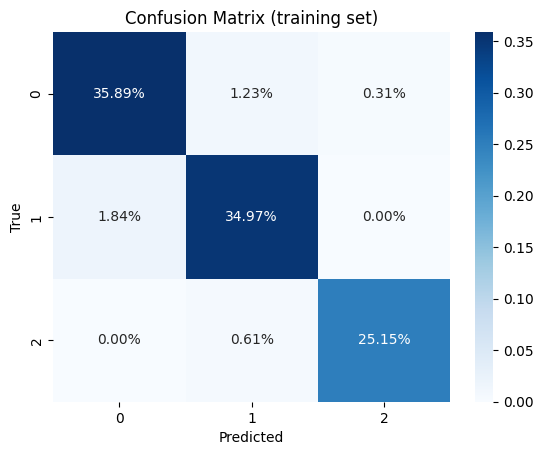

[[15  8  4]
 [14 18  6]
 [ 4  7  6]]


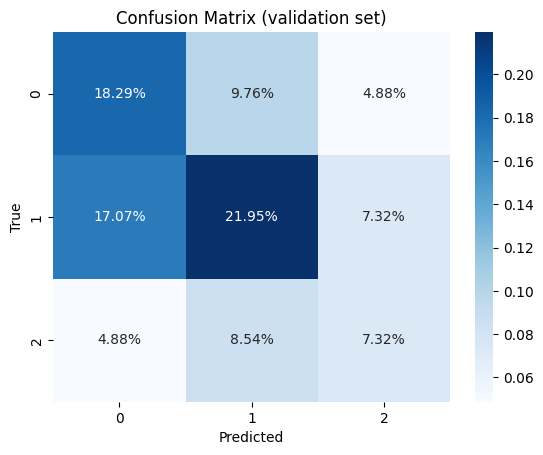

In [43]:
model  = opt_model

import seaborn as sns
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report

# Making predictions
pred_train = model.predict(x_train_emb)
pred_val = model.predict(x_val_emb)
pred_test = model.predict(x_test_emb)

# Converting predictions to binary arrays
def to_binary(pred):
    pred_binary = np.zeros(pred.shape)
    for i in range(len(pred)):
        pred_binary[i, pred[i, :].argmax()] = 1
    return pred_binary

pred_train_2 = to_binary(pred_train)
pred_val_2 = to_binary(pred_val)
pred_test_2 = to_binary(pred_test)

# Converting predictions to class labels
y_train_pred_labels = np.argmax(pred_train, axis=1)
y_val_pred_labels = np.argmax(pred_val, axis=1)
y_test_pred_labels = np.argmax(pred_test, axis=1)

# Converting one-hot encoded true labels to class labels
y_train_true_labels = np.argmax(y_train_dummy, axis=1)
y_val_true_labels = np.argmax(y_val_dummy, axis=1)
y_test_true_labels = np.argmax(y_test_dummy, axis=1)

# Evaluating the model (training and validation set)

# Classification report (training set)
class_names = ['Class 0', 'Class 1', 'Class 2']
print("Classification Report (training set):")
print(classification_report(y_train_true_labels, y_train_pred_labels, target_names=class_names))

# Classification report (validation set)
class_names = ['Class 0', 'Class 1', 'Class 2']
print("Classification Report (validation set):")
print(classification_report(y_val_true_labels, y_val_pred_labels, target_names=class_names))

# Confusion matrix (training set)
print(confusion_matrix(y_train_true_labels, y_train_pred_labels))
conf_matrix = confusion_matrix(y_train_true_labels, y_train_pred_labels)
sns.heatmap(conf_matrix/np.sum(conf_matrix), annot=True, fmt='.2%', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix (training set)')
plt.show()

# Confusion matrix (validation set)
print(confusion_matrix(y_val_true_labels, y_val_pred_labels))
conf_matrix = confusion_matrix(y_val_true_labels, y_val_pred_labels)
sns.heatmap(conf_matrix/np.sum(conf_matrix), annot=True, fmt='.2%', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix (validation set)')
plt.show()

**Class Performance**
*   The model has a balanced performance for Class 0 with reasonable precision (0.45) and recall (0.56), resulting in an F1-score of 0.50
*   Class 1 has the highest precision (0.55) among the classes but a lower recall (0.47), resulting in an F1-score of 0.51
*   The model struggles with Class 2, showing lower precision (0.38) and recall (0.35), resulting in an F1-score of 0.36

**Overall Performance**
*   Accuracy of 48% is moderate
*   Precision (0.48), recall (0.48), and F1-score (0.47) are moderate
*   Model has a balanced performance across classes

## Test set and conclusions

Comparing the three models it can be said that Text2Vec-base-multilingual model is better because of highest accuracy and balanced precision, recall, and F1-scores across all classes.

Now we will evalue the Text2Vec-base-multilingual model on the test set.

4/4 [==============================] - 0s 3ms/step
Classification Report (test set):
              precision    recall  f1-score   support

     Class 0       0.39      0.61      0.48        33
     Class 1       0.45      0.35      0.39        43
     Class 2       0.22      0.15      0.18        26

    accuracy                           0.38       102
   macro avg       0.36      0.37      0.35       102
weighted avg       0.38      0.38      0.37       102

[[20  8  5]
 [19 15  9]
 [12 10  4]]


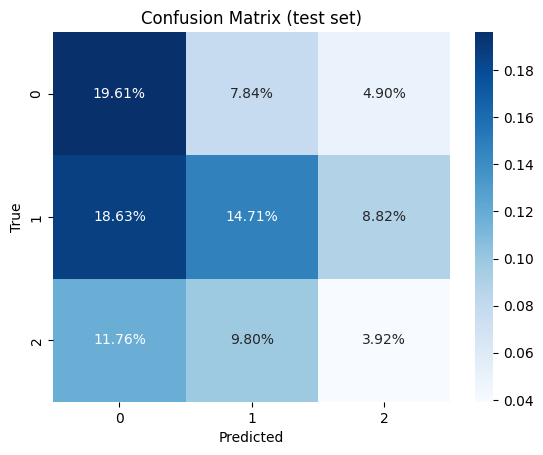

In [44]:
# Evaluating the Text2Vec model on test set

#model  = opt_model

#import seaborn as sns
#import matplotlib.pyplot as plt
#from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report

# Making predictions
pred_test = model.predict(x_test_emb)

# Converting predictions to binary arrays
#def to_binary(pred):
    #pred_binary = np.zeros(pred.shape)
    #for i in range(len(pred)):
        #pred_binary[i, pred[i, :].argmax()] = 1
    #return pred_binary


pred_test_2 = to_binary(pred_test)

# Converting predictions to class labels
y_test_pred_labels = np.argmax(pred_test, axis=1)

# Converting one-hot encoded true labels to class labels
y_test_true_labels = np.argmax(y_test_dummy, axis=1)

#Classification report (test set)
class_names = ['Class 0', 'Class 1', 'Class 2']
print("Classification Report (test set):")
print(classification_report(y_test_true_labels, y_test_pred_labels, target_names=class_names))

# Confusion matrix (test set)
print(confusion_matrix(y_test_true_labels, y_test_pred_labels))
conf_matrix = confusion_matrix(y_test_true_labels, y_test_pred_labels)
sns.heatmap(conf_matrix/np.sum(conf_matrix), annot=True, fmt='.2%', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix (test set)')
plt.show()

Models performance on the test dataset is moderate and is consistent with its performance on the validation set, indicating stability in its predictive capabilities.